## Recipe Reviews and User Feedback Dataset

Analysis
- understand data / feature exploaration
- target distribution
- input sentence 

ML: Sentiment Analysis
- "review text" column as the predictive attribute
- "best score" column, which categorizes reviews into five classes: "very positive," "positive," "neutral," "negative," and "very negative," as the target attribute for our analysis\
`best score was score of the comment, likely used by the site the help determine the order the comments appear in. This dataset does not contain values for sentiment analysis`

https://www.ijnrd.org/papers/IJNRD2310077.pdf



In [47]:
import pandas as pd
import numpy
from plotnine import *
from datetime import datetime

In [2]:
df = pd.read_csv("Recipe Reviews and User Feedback Dataset.csv")

In [4]:
# save as parquet
df.to_parquet("RRUFD.parquet")

In [5]:
df = pd.read_parquet("RRUFD.parquet")

In [6]:
df.columns

Index(['Unnamed: 0', 'recipe_number', 'recipe_code', 'recipe_name',
       'comment_id', 'user_id', 'user_name', 'user_reputation', 'created_at',
       'reply_count', 'thumbs_up', 'thumbs_down', 'stars', 'best_score',
       'text'],
      dtype='object')

In [38]:
df.isna().sum()

Unnamed: 0         0
recipe_number      0
recipe_code        0
recipe_name        0
comment_id         0
user_id            0
user_name          0
user_reputation    0
created_at         0
reply_count        0
thumbs_up          0
thumbs_down        0
stars              0
best_score         0
text               2
dtype: int64

In [40]:
df[df["text"].isna()]

,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
1507,344,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_260955,u_1oKZmfyycO3xVnQeffIKHuaKT2U,No.1FamilyBaker,1,1622717645,0,0,0,5,100,None
2722,299,6,21444,Favorite Chicken Potpie,sp_aUSaElGf_21444_c_260817,u_1oKXz42APTrXTFF6SGvR3YMBJGy,TRGriggs,1,1622717652,0,0,0,5,100,None


In [19]:
cdf = df[["recipe_name", "recipe_number"]].value_counts().iloc[:20].to_frame().reset_index()

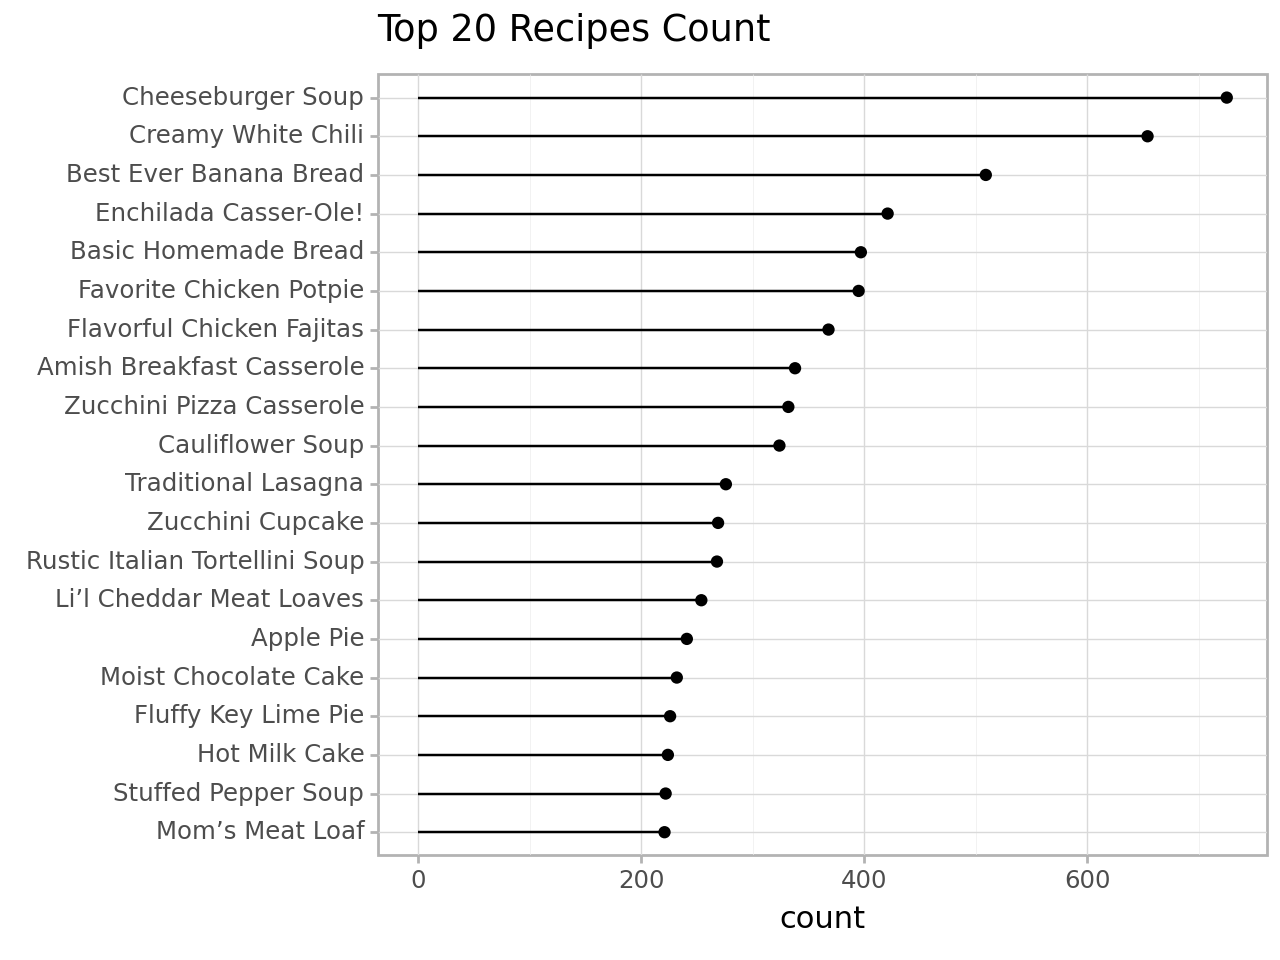

<Figure Size: (640 x 480)>

In [34]:
recipe_list = df["recipe_name"].value_counts().iloc[:20].index.to_list()[::-1]

(ggplot(cdf, aes(x="recipe_name", y="count")) +
 geom_point() +
 geom_segment(aes(xend="recipe_name", yend=0)) +
 scale_x_discrete(limits=recipe_list) +
 coord_flip() +
 theme_light() +
 labs(x="", title="Top 20 Recipes Count"))

In [45]:
df["stars"].value_counts().sort_index()

stars
0     1696
1      280
2      232
3      490
4     1655
5    13829
Name: count, dtype: int64

In [50]:
# time and comment count
df["created_time"] = df["created_at"].map(datetime.utcfromtimestamp)

In [54]:
df["created_time"].max(), df["created_time"].min()

(Timestamp('2022-10-14 14:00:35'), Timestamp('2021-02-11 09:22:16'))

In [55]:
# range of days that authors collected data
df["created_time"].max() - df["created_time"].min()

Timedelta('610 days 04:38:19')

In [57]:
# get date only
df["created_date"] = df["created_time"].map(lambda d : d.date())

In [88]:
df["created_time"].sample(10)

570     2021-06-03 11:04:58
10313   2021-06-03 10:56:23
4316    2021-06-03 10:51:20
9486    2021-06-03 10:42:39
4948    2021-06-03 11:04:03
5800    2021-06-03 10:48:37
7075    2021-06-03 10:59:25
16051   2021-06-03 10:57:01
12444   2021-06-03 10:52:24
851     2021-06-03 11:01:47
Name: created_time, dtype: datetime64[ns]

In [78]:
df["created_date"].value_counts()

created_date
2021-06-03    16695
2021-06-02      413
2021-02-11       87
2021-02-12       14
2021-06-14        8
              ...  
2021-09-22        1
2021-05-24        1
2022-05-06        1
2022-08-23        1
2022-02-01        1
Name: count, Length: 440, dtype: int64

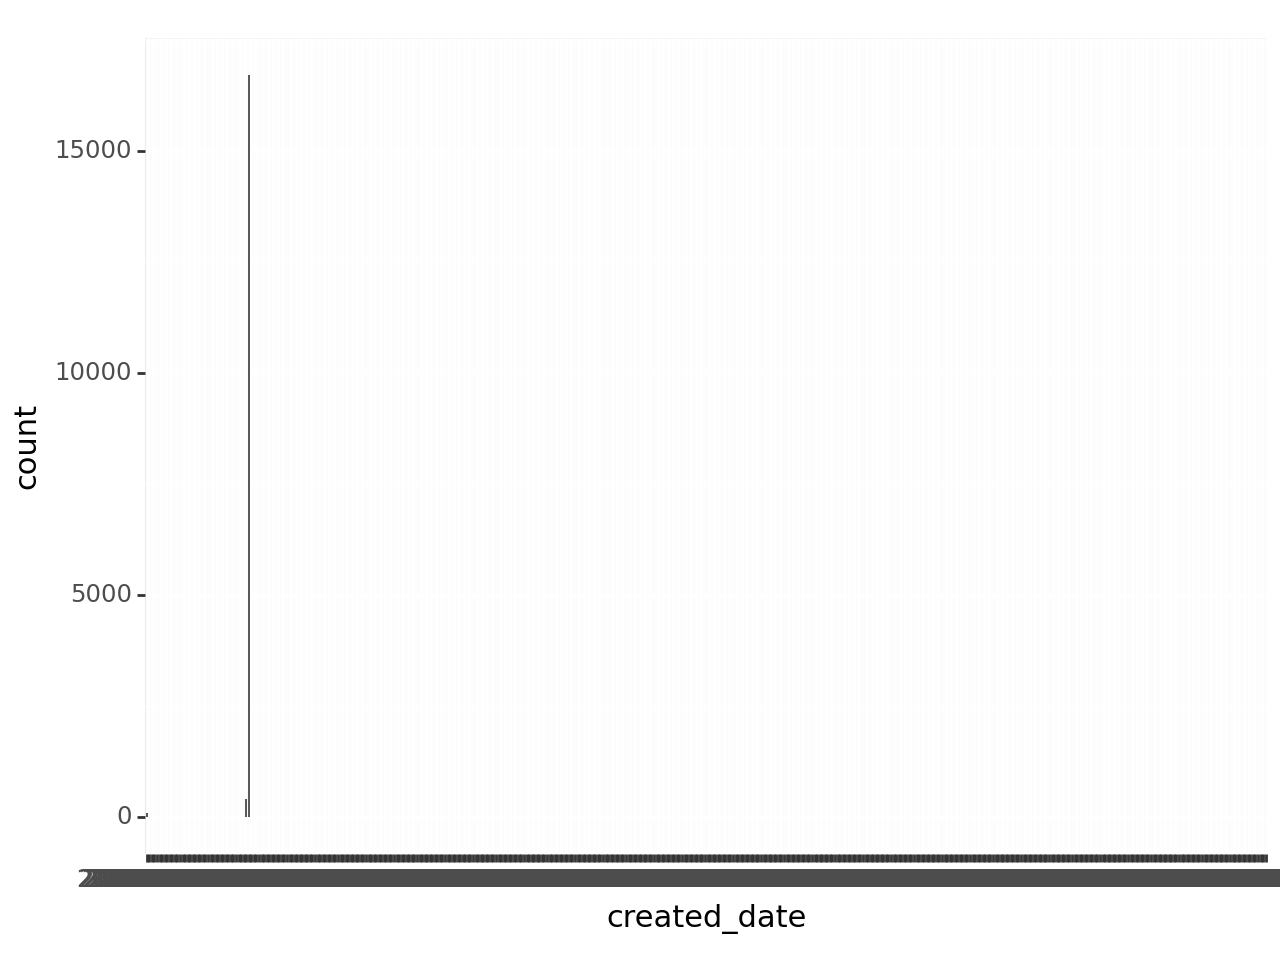

<Figure Size: (640 x 480)>

In [58]:
(ggplot(df, aes(x="created_date")) +
 geom_bar())

## Note on created_at column

The majority of comments are created on 2021-06-03 (16695 out of 18182), which seems unusual. Since the timestamp is unix time, there is no timezone. \
Possible scenario is that the comments data is moved from a server to another due to maintainance or something, and all these comments got the same timestamp. However, when we take a closer look, each comment data on 2021-06-03 have different times. If this trend is caused by data migration action, they should all have the same time stamp given based on the size of data. Hence, this scenario is not likely the case.

The possible issue caused by this is that the season when users tried recipes may affect the sentiment of the comments. For instance, typically, warmer meals are more enjoyable in winter time. Having the same dates on majority of the comments poses a question on the validity of comments. Are these comments in the dataset actually legitimate?

In [106]:
tmp = df[["recipe_name","recipe_code"]].value_counts().iloc[:5].to_frame().reset_index()
top_recipes = tmp["recipe_code"].to_list()
top_recipes

[2832, 14299, 3309, 42083, 32480]

In [108]:
# thumbs up/down
thumbs = df[["comment_id", "recipe_code", "recipe_name",
            "thumbs_up", "thumbs_down", "text"]]
thumbs = thumbs.query("thumbs_up > 0 or thumbs_down > 0")
len(thumbs)

4799

In [109]:
thumbs["recipe_name"] = thumbs.apply(lambda row : 
                                     row["recipe_name"] if row["recipe_code"] in top_recipes
                                     else "Other", axis=1)

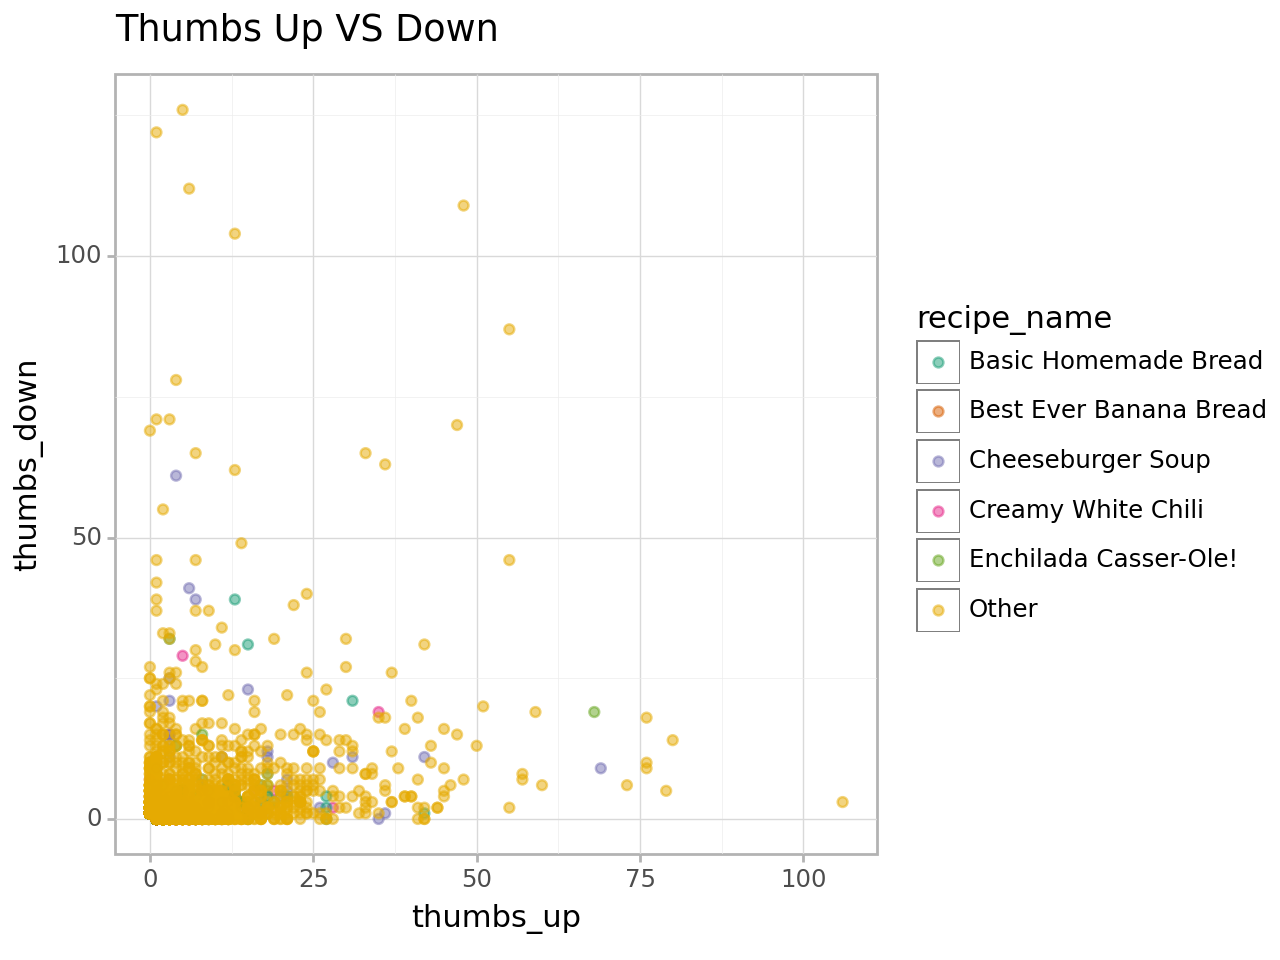

<Figure Size: (640 x 480)>

In [115]:
(ggplot(thumbs, aes(x="thumbs_up", y="thumbs_down",
                    fill="recipe_name",
                    color="recipe_name")) +
 geom_point(alpha=0.5) +
 scale_fill_brewer(type = "qual", palette="Dark2") +
 scale_color_brewer(type = "qual", palette="Dark2") +
 theme_light() +
 labs(title="Thumbs Up VS Down"))

In [98]:
# comments with more reactions might be more interesting
high_comments = thumbs.query("thumbs_up > 50 or thumbs_down > 50")

comment_id        sp_aUSaElGf_2832_c_1xETpSVM9yR69ApipJFaCeraf5k
thumbs_up                                                     69
thumbs_down                                                    9
text           This looks delicious.  If I want to make it in...
Name: 1192, dtype: object

In [103]:
list(high_comments["text"].sample(5))

['I made this,. \xa0Therefore, I would not recommend.  Then I made it my way.  Instead of flour I added an extra cup of potatoes.  Then after boiling potatoes in chicken broth, removed a cup of potatoes and mashed them.  Returned to pot, added a little cream.  and had a deliciously thickened soup.  Oh and I never use cheese.  It’s not needed if you season your potatoes properly.',
 'I love it it is the BEST SOUP EVER that is why i gave it one star',
 'As with any recipe one tends to adjust to their own taste. That being said TOH altered my original submission of this recipe!  I don&#39;t do all those layers and use only 2 layers of noodles (6 total). I continue to adjust my recipe twenty years later! Isn&#39;t that what all cooks do as we learn?  One thing I will say is you must use fresh ingredients to get the best results - like shred the mozzarella (preshredded cheese contains chemicals that keep the cheese from caking and DOES affect the results). Also, don&#39;t use cheap ingredie

## Last Comments

The dataset does not seem to have a target column used for sentiment classification task.\
The comments with higher reaction counts (thumbs up/down) do not always belong to the recipes with higher comment counts.